In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


## Preparing Data

In [4]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Karawang")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974
...,...,...,...,...
3643,1999-06-12 19:00:00,3644,0.297,4.675316
3644,1999-06-12 20:00:00,3645,0.297,4.597948
3645,1999-06-12 21:00:00,3646,0.250,4.480365
3646,1999-06-12 22:00:00,3647,0.250,4.327907


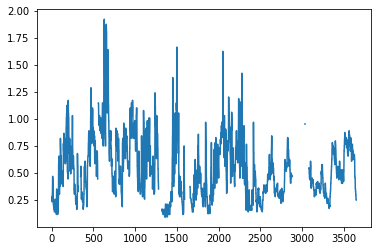

In [5]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [6]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

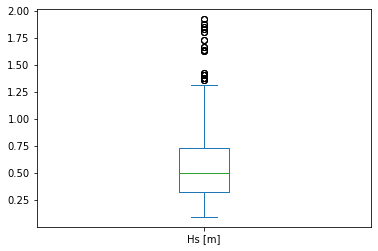

In [ ]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [ ]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [ ]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

624     1.828
625     1.828
626     1.828
627     1.922
628     1.922
629     1.922
630     1.734
631     1.734
632     1.734
633     1.406
634     1.406
635     1.406
648     1.852
649     1.852
650     1.852
651     1.875
652     1.875
653     1.875
654     1.805
655     1.805
656     1.805
657     1.406
658     1.406
659     1.406
672     1.641
673     1.641
674     1.641
675     1.383
676     1.383
677     1.383
1449    1.383
1450    1.383
1451    1.383
1497    1.664
1498    1.664
1499    1.664
1500    1.359
1501    1.359
1502    1.359
2049    1.625
2050    1.625
2051    1.625
2277    1.422
2278    1.422
2279    1.422
Name: Hs [m], dtype: float64

In [ ]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1999-01-12 00:00:00,1,0.281,3.450012
1,1999-01-12 01:00:00,2,0.281,3.195916
2,1999-01-12 02:00:00,3,0.281,3.480425
3,1999-01-12 03:00:00,4,0.234,3.734589
4,1999-01-12 04:00:00,5,0.234,3.478974


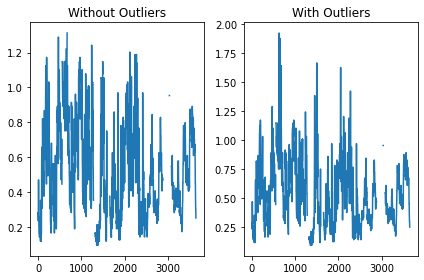

In [ ]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [7]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [8]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [9]:
# drop NaN value in dataframe data
data = data.dropna()

In [10]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [11]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [12]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [13]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [14]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-14-86623d2f7eed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Hs [m]'][i-1] = y_fc(i)
<ipython-input-14-86623d2f7eed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Hs [m]'][i-1] = y_fq(i)
<ipython-input-14-86623d2f7eed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Hs [m]'][i-1] = y_fl(i)


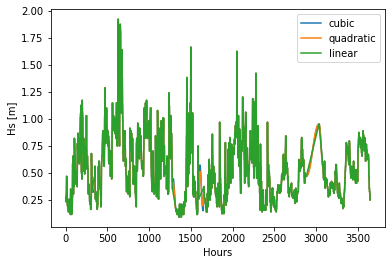

In [15]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

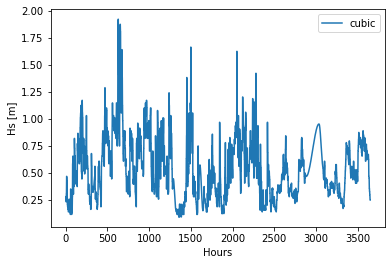

In [16]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

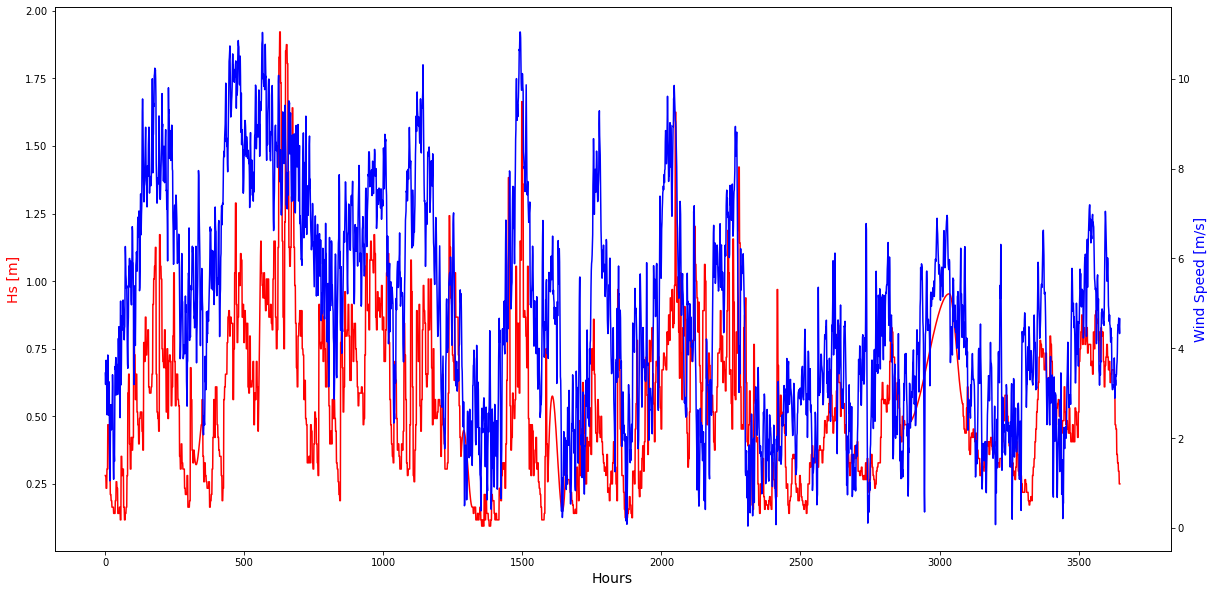

In [17]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [18]:
data_swh = data2['Hs [m]']
type(data_swh), data_swh.shape

(pandas.core.series.Series, (3648,))

In [19]:
len(data_swh)

3648

In [20]:
data_swh[1:5]

1    0.281
2    0.281
3    0.234
4    0.234
Name: Hs [m], dtype: float64

**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [21]:
train = data_swh[:2556]
val = data_swh[2556:2928]
test = data_swh[2928:]
train.shape, val.shape, test.shape

((2556,), (372,), (720,))

In [22]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((213, 12), (31, 12), (60, 12))

In [23]:
n_input,n_out = 12,12
data_train = train.reshape((train.shape[0]*train.shape[1], ))
data_val = val.reshape((val.shape[0]*val.shape[1], ))
data_train.shape, data_val.shape

((2556,), (372,))

In [24]:
len(data_train)

2556

In [25]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [26]:
n_steps_in, n_steps_out = 12, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2533, 12), (2533, 12), (349, 12), (349, 12))

In [27]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((2533, 12, 1), (349, 12, 1))

## Model

In [28]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 12)                1212      
                                                                 
Total params: 52,112
Trainable params: 52,112
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1])

Epoch 1/50
79/80 [============================>.] - ETA: 0s - loss: 0.3571 - root_mean_squared_error: 0.5976

80/80 [==============================] - 8s 66ms/step - loss: 0.3574 - root_mean_squared_error: 0.5978 - val_loss: 0.1521 - val_root_mean_squared_error: 0.3900
Epoch 2/50
78/80 [============================>.] - ETA: 0s - loss: 0.1720 - root_mean_squared_error: 0.4148

80/80 [==============================] - 4s 52ms/step - loss: 0.1703 - root_mean_squared_error: 0.4127 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 3/50
79/80 [============================>.] - ETA: 0s - loss: 0.0647 - root_mean_squared_error: 0.2543

80/80 [==============================] - 4s 50ms/step - loss: 0.0646 - root_mean_squared_error: 0.2542 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009
Epoch 4/50
76/80 [===========================>..] - ETA: 0s - loss: 0.0552 - root_mean_squared_error: 0.2350

80/80 [==============================] - 4s 46ms/step - loss: 0.0549 - root_mean_squared_error: 0.2344 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 5/50
79/80 [============================>.] - ETA: 0s - loss: 0.0533 - root_mean_squared_error: 0.2308

80/80 [==============================] - 3s 36ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 6/50
80/80 [==============================] - 1s 12ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 7/50
77/80 [===========================>..] - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.2281

80/80 [==============================] - 3s 36ms/step - loss: 0.0518 - root_mean_squared_error: 0.2275 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 8/50
80/80 [==============================] - 1s 16ms/step - loss: 0.0510 - root_mean_squared_error: 0.2257 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 9/50
80/80 [==============================] - 2s 21ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 10/50
77/80 [===========================>..] - ETA: 0s - loss: 0.0494 - root_mean_squared_error: 0.2223

80/80 [==============================] - 4s 46ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 11/50
80/80 [==============================] - 1s 12ms/step - loss: 0.0491 - root_mean_squared_error: 0.2216 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 12/50
80/80 [==============================] - 1s 13ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 13/50
79/80 [============================>.] - ETA: 0s - loss: 0.0483 - root_mean_squared_error: 0.2199

80/80 [==============================] - 4s 56ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0942
Epoch 14/50
80/80 [==============================] - 1s 13ms/step - loss: 0.0480 - root_mean_squared_error: 0.2190 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 15/50
80/80 [==============================] - 1s 15ms/step - loss: 0.0477 - root_mean_squared_error: 0.2183 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 16/50
79/80 [============================>.] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.2177

80/80 [==============================] - 4s 52ms/step - loss: 0.0474 - root_mean_squared_error: 0.2176 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 17/50
80/80 [==============================] - 1s 12ms/step - loss: 0.0471 - root_mean_squared_error: 0.2170 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0982
Epoch 18/50
80/80 [==============================] - 1s 13ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 19/50
78/80 [============================>.] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.2160

80/80 [==============================] - 3s 36ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 20/50
78/80 [============================>.] - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.2155

80/80 [==============================] - 3s 41ms/step - loss: 0.0463 - root_mean_squared_error: 0.2153 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 21/50
78/80 [============================>.] - ETA: 0s - loss: 0.0464 - root_mean_squared_error: 0.2154

80/80 [==============================] - 4s 45ms/step - loss: 0.0463 - root_mean_squared_error: 0.2152 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 22/50
80/80 [==============================] - 2s 20ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978
Epoch 23/50
80/80 [==============================] - 1s 17ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 24/50
80/80 [==============================] - 1s 12ms/step - loss: 0.0457 - root_mean_squared_error: 0.2137 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 25/50
80/80 [==============================] - 1s 13ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 26/50
80/80 [==============================] - 1s 13ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0094 - val_root_mean_sq

80/80 [==============================] - 3s 40ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 32/50
80/80 [==============================] - 2s 21ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995
Epoch 33/50
80/80 [==============================] - 2s 20ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 34/50
80/80 [==============================] - 1s 14ms/step - loss: 0.0441 - root_mean_squared_error: 0.2101 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 35/50
80/80 [==============================] - 1s 17ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 36/50
80/80 [==============================] - 1s 17ms/step - loss: 0.0438 - root_mean_squared_error: 0.2093 - val_loss: 0.0087 - val_root_mean_sq

In [31]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [32]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], ))
  input_x = data[-n_input:, ]
  input_x = input_x.reshape((1, len(input_x), 1))
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])

In [45]:
prediksi = array(predictions)
observasi = test
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [46]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results

,Univariate,Actuals
0,0.577189,0.577203
1,0.572779,0.581304
2,0.566224,0.585453
3,0.565036,0.589647
4,0.550753,0.593886
...,...,...
715,0.512835,0.297000
716,0.515522,0.297000
717,0.518507,0.250000
718,0.528328,0.250000


In [47]:
prediksi = array(predictions)
observasi = test[:, :, ]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [48]:
test_results['Date'] = data2['Date'].iloc[2928:].values
test_results.head()

,Univariate,Actuals,Date
0,0.577189,0.577203,1999-05-14 00:00:00
1,0.572779,0.581304,1999-05-14 01:00:00
2,0.566224,0.585453,1999-05-14 02:00:00
3,0.565036,0.589647,1999-05-14 03:00:00
4,0.550753,0.593886,1999-05-14 04:00:00


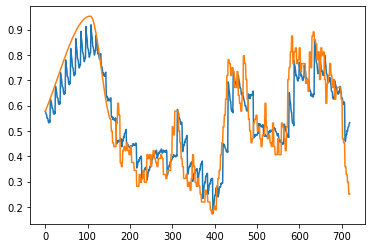

In [49]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [39]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.09844334663876991

In [40]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

0.894075256956792

In [41]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.013130308510217355

In [ ]:
test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/univariate_12jam_lstm_karawang.csv')